# Building a neural network to perform a complex task such as Digit Recognition and in the process get to learn about backpropagation algorithm

In [0]:
from scipy.io import loadmat
import numpy as np
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from google.colab import files
files.upload()

Saving ex4data1.mat to ex4data1 (1).mat
Saving ex4weights.mat to ex4weights.mat


**Feedforward Propagation**

First implement feedforward propagation for neural network with the already given weights. Then, we will implement the backpropagation algorithm to learn the parameters for ourselves. Here I use the terms weights and parameters interchangeably.

**Visualising the data:**

Each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image. The second part of the training set is a 5000-dimensional vector y that contains labels for the training set.

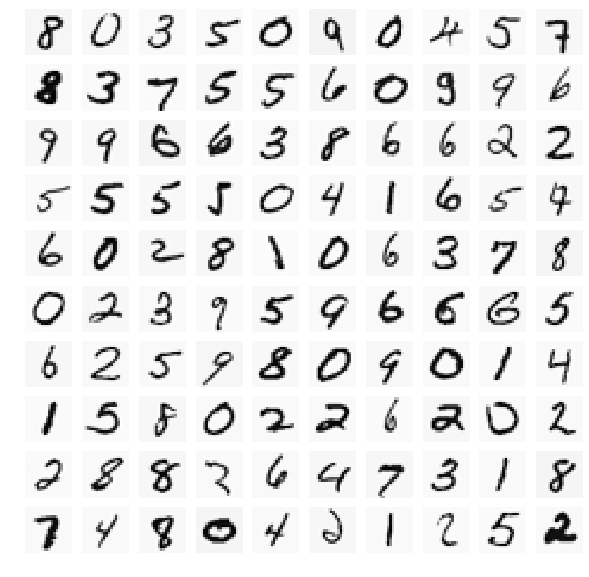

In [0]:
# Read the data
data = loadmat('ex4data1.mat')
X = data['X']
y = data['y']

# Visualising the data
_, axarr = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
       axarr[i,j].imshow(X[np.random.randint(X.shape[0])].\
reshape((20,20), order = 'F'))          
       axarr[i,j].axis('off')

We have been provided with a set of already trained network parameters. These are stored in ex4weights.mat and will be loaded into theta1 and theta2 followed by unrolling into a vector nn_params. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [0]:
weights = loadmat('ex4weights.mat')
theta1 = weights['Theta1']                                                   # Theta1 has size 25 x 401
theta2 = weights['Theta2']                                                   # Theta2 has size 10 x 26
nn_params = np.hstack((theta1.ravel(order='F'), theta2.ravel(order='F')))    # Unroll parameters

# Neural network hyperparameters
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
lmbda = 1

**Sigmoid function**

In [0]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

**Cost function**

In [0]:
def nnCostFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
    theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')

    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)
    
    y_d = pd.get_dummies(y.flatten())
    
    temp1 = np.multiply(y_d, np.log(h))
    temp2 = np.multiply(1-y_d, np.log(1-h))
    temp3 = np.sum(temp1 + temp2)
    
    sum1 = np.sum(np.sum(np.power(theta1[:,1:],2), axis = 1))
    sum2 = np.sum(np.sum(np.power(theta2[:,1:],2), axis = 1))
    
    return np.sum(temp3 / (-m)) + (sum1 + sum2) * lmbda / (2*m)

In [26]:
nnCostFunc(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

0.38376985909092354

**Calling nnCostFunc using the given weights gives us the cost, 0.38.**

**Backpropagation**

In this part of the exercise, we'll implement the ***backpropagation algorithm*** to compute the gradients for the neural network. Once computed the gradient, you will be able to train the neural network by minimising the cost function using an advanced optimizer such as fmincg.

**Sigmoid gradient**

We will first implement the sigmoid gradient function. The gradient for the sigmoid function can be computed as

In [0]:
def sigmoidGrad(z):
    return np.multiply(sigmoid(z), 1-sigmoid(z))

**Random initialisation**

When training neural networks, it's important to randomly initialise the parameters for symmetry breaking. Here I randomly initialise parameters named initial_theta1 and initial_theta2 corresponding to hidden layer and output layer and unroll into a single vector as I did earlier.

In [0]:
def randInitializeWeights(L_in, L_out):
    epsilon = 0.12
    return np.random.rand(L_out, L_in+1) * 2 * epsilon - epsilon

initial_theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unrolling parameters into a single column vector
nn_initial_params = np.hstack((initial_theta1.ravel(order='F'), initial_theta2.ravel(order='F')))

**Backpropagation**

In summary we do the following by looping through every training example:

1. Compute the forward propagate to get the output activation a3.

2. Compute the error term d3 that’s obtained by subtracting actual output from our calculated output a3.

3. For hidden layer, error termd2 can be calculated as below:

4. Accumulate the gradients in delta1 and delta2 .

5. Obtain the gradients for the neural network by diving the accumulated gradients (of step 4) by m.

6. Add the regularisation terms to the gradients.

In [0]:
def nnGrad(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda):
    
    initial_theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
    initial_theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')
    y_d = pd.get_dummies(y.flatten())
    delta1 = np.zeros(initial_theta1.shape)
    delta2 = np.zeros(initial_theta2.shape)
    m = len(y)
    
    for i in range(X.shape[0]):
        ones = np.ones(1)
        a1 = np.hstack((ones, X[i]))
        z2 = a1 @ initial_theta1.T
        a2 = np.hstack((ones, sigmoid(z2)))
        z3 = a2 @ initial_theta2.T
        a3 = sigmoid(z3)

        d3 = a3 - y_d.iloc[i,:][np.newaxis,:]
        z2 = np.hstack((ones, z2))
        d2 = np.multiply(initial_theta2.T @ d3.T, sigmoidGrad(z2).T[:,np.newaxis])
        delta1 = delta1 + d2[1:,:] @ a1[np.newaxis,:]
        delta2 = delta2 + d3.T @ a2[np.newaxis,:]
        
    delta1 /= m
    delta2 /= m
    
    # Print(delta1.shape, delta2.shape)
    delta1[:,1:] = delta1[:,1:] + initial_theta1[:,1:] * lmbda / m
    delta2[:,1:] = delta2[:,1:] + initial_theta2[:,1:] * lmbda / m
        
    return np.hstack((delta1.ravel(order='F'), delta2.ravel(order='F')))

By the way, the for-loop in the above code can be eliminated if you can use a highly vectorised implementation. But for those who are new to backprop it is okay to use for-loop to gain a much better understanding. Running the above function with initial parameters gives nn_backprop_Params which we will be using while performing gradient checking.

In [0]:
nn_backprop_Params = nnGrad(nn_initial_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmbda)

**Gradient checking**

**Why do we need Gradient checking ?** To make sure that our backprop algorithm has no bugs in it and works as intended. We can approximate the derivative of our cost function by:

The gradient computed using backprop and numerical approximation should agree to at least 4 significant digits to make sure that our backprop implementation is bug free.

In [0]:
def checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = nn_initial_params
    flattenedDs = nn_backprop_Params
    n_elems = len(flattened)
    
    # Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in range(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps

        cost_high = nnCostFunc(flattened + epsvec.flatten(),input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda)
        cost_low  = nnCostFunc(flattened - epsvec.flatten(),input_layer_size, hidden_layer_size, num_labels,myX,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)

        print("Element: {0}. Numerical Gradient = {1:.9f}. BackProp Gradient = {2:.9f}.".format(x,mygrad,flattenedDs[x]))

In [31]:
checkGradient(nn_initial_params,nn_backprop_Params,input_layer_size, hidden_layer_size, num_labels,X,y,lmbda)

Element: 9450. Numerical Gradient = -0.000013162. BackProp Gradient = -0.000013162.
Element: 1803. Numerical Gradient = 0.000644930. BackProp Gradient = 0.000644930.
Element: 2102. Numerical Gradient = 0.000161341. BackProp Gradient = 0.000161341.
Element: 7054. Numerical Gradient = 0.000023559. BackProp Gradient = 0.000023559.
Element: 4343. Numerical Gradient = -0.005156281. BackProp Gradient = -0.005156281.
Element: 9404. Numerical Gradient = 0.000021781. BackProp Gradient = 0.000021781.
Element: 9661. Numerical Gradient = 0.000001869. BackProp Gradient = 0.000001869.
Element: 400. Numerical Gradient = 0.000015359. BackProp Gradient = 0.000015359.
Element: 9659. Numerical Gradient = 0.000020388. BackProp Gradient = 0.000020388.
Element: 4099. Numerical Gradient = -0.000287716. BackProp Gradient = -0.000287716.


**Learning parameters using fmincg**

After you have successfully implemented the neural network cost function and gradient computation, the next step is to use fmincg to learn a good set of parameters for the neural network. theta_opt contains unrolled parameters that we just learnt which we roll to get theta1_opt and theta2_opt.

In [32]:
theta_opt = opt.fmin_cg(maxiter = 50, f = nnCostFunc, x0 = nn_initial_params, fprime = nnGrad, \
                        args = (input_layer_size, hidden_layer_size, num_labels, X, y.flatten(), lmbda))

theta1_opt = np.reshape(theta_opt[:hidden_layer_size*(input_layer_size+1)], (hidden_layer_size, input_layer_size+1), 'F')
theta2_opt = np.reshape(theta_opt[hidden_layer_size*(input_layer_size+1):], (num_labels, hidden_layer_size+1), 'F')

         Current function value: 0.440885
         Iterations: 50
         Function evaluations: 106
         Gradient evaluations: 106


**Prediction using learned parameters**

It’s time to see how well our newly learned parameters are performing by calculating the accuracy of the model. Do recall that when we used linear classifier like Logistic Regression we got an accuracy of 95.08%. Neural network should give us a better accuracy.

In [0]:
def predict(theta1, theta2, X, y):
    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)
    return np.argmax(h, axis = 1) + 1

In [34]:
pred = predict(theta1_opt, theta2_opt, X, y)
np.mean(pred == y.flatten()) * 100

95.92

# A 96% accuracy. It is to be noted that by tweaking the hyperparameters we can still obtain a better accuracy.